In [ ]:
!pip install scikeras --upgrade
!pip install scikit-learn --upgrade
!pip install keras --upgrade


  Using cached keras-3.10.0-py3-none-any.whl.metadata (6.0 kB)
Using cached keras-3.10.0-py3-none-any.whl (1.4 MB)
  Using cached keras-3.10.0-py3-none-any.whl.metadata (6.0 kB)
Using cached keras-3.10.0-py3-none-any.whl (1.4 MB)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


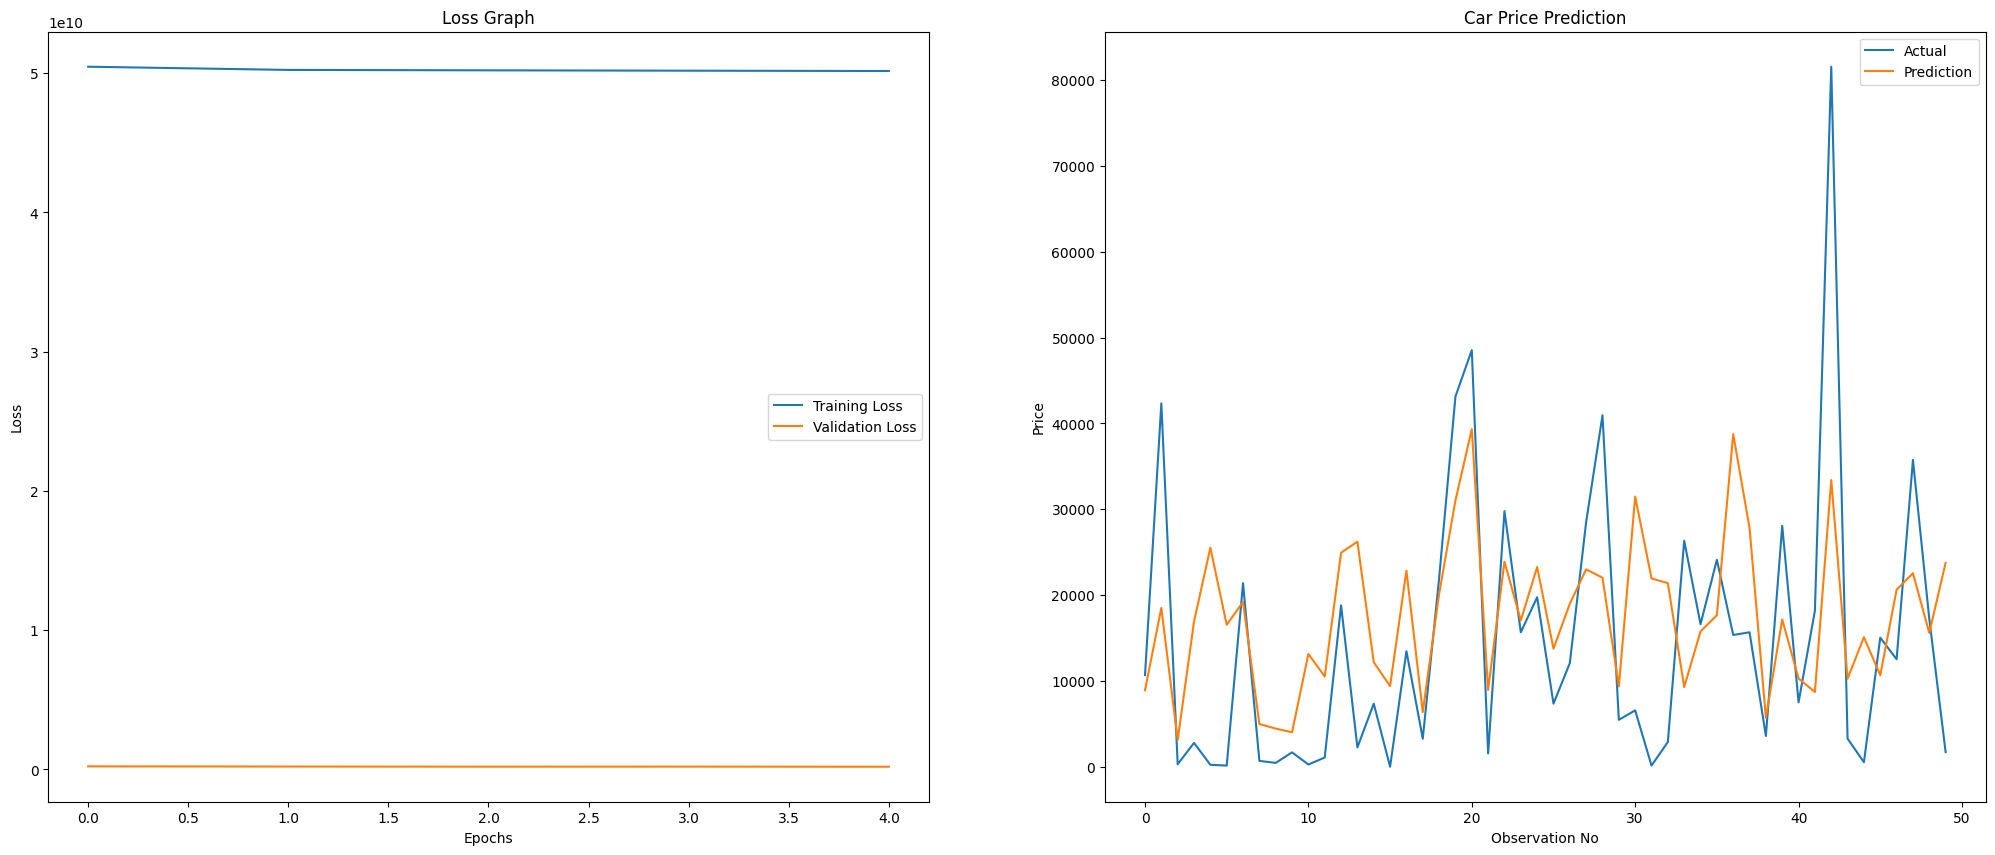

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
import zipfile
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.optimizers import Adam


df_zip=zipfile.ZipFile("/content/car_price_prediction.csv.zip")
veri=pd.read_csv(df_zip.open("car_price_prediction.csv"), low_memory=False)


veri=veri.drop(columns="ID")
#veri.isnull().sum()
#veri.info()
#veri["Levy"].unique()

veri["Levy"]=veri["Levy"].replace("-", np.nan)
#veri.isnull().sum()

veri["Levy"]=veri["Levy"].fillna(0)
veri["Levy"]=veri["Levy"].astype(int)
#veri.isnull().sum()
#veri.info()


#veri["Manufacturer"].unique()

#veri["Engine volume"].unique()

veri["Turbo"]=veri["Engine volume"].apply(lambda x:"Turbo" if "Turbo"in str(x) else "Non Turbo")
veri["Engine volume"]=veri["Engine volume"].apply(lambda x:str(x).replace("Turbo", '')).astype(float)
#veri.info()


veri["Mileage"]=veri["Mileage"].apply(lambda x:x.split(" ")[0]).astype(int)
#veri.info()
veri["Cylinders"]=veri["Cylinders"].astype(int)
#veri.info()


veri["Doors"]=np.where(veri["Doors"]=="04-May", 4, veri["Doors"])
veri["Doors"]=np.where(veri["Doors"]=="02-Mar", 2, veri["Doors"])
veri["Doors"]=np.where(veri["Doors"]==">5", 5, veri["Doors"])
veri["Doors"]=veri["Doors"].astype(int)

cat=[]

for i in veri.columns:
  if veri[i].dtypes=="object":
    cat.append(i)


le=LabelEncoder()

for i in cat:
  veri[i]=le.fit_transform(veri[i])

y=veri["Price"]
x=veri.drop(columns="Price")

sc=StandardScaler()
x=sc.fit_transform(x)

x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.2,random_state=0)
x_train, x_val, y_train, y_val=train_test_split(x_train,y_train,test_size=0.1,random_state=0)


#plt.figure(figsize=(25,10))
#plt.plot(output.history["loss"])
#plt.plot(output.history["val_loss"])
#plt.title("Loss Graph")
#plt.ylabel("Loss")
#plt.xlabel("Epochs")
#plt.legend(["Training", "Validation"], loc="upper right")
#plt.show()



#plt.figure(figsize=(25,10))
#plt.plot(range(len(y_test[:50])), y_test[:50], label="Actual")
#plt.plot(range(len(y_test[:50])), prediction[:50], label="Prediction")
#plt.title("Car Price Prediction")
#plt.xlabel("Observation No")
#plt.ylabel("Price")
#plt.legend()
#plt.show()




def modelkur(units=64, activation="linear", learning_rate=0.01, hidden_layers=2, dropout_rate=0.2):

  model=Sequential()
  model.add(Dense(units=units, input_dim=x_train.shape[1], activation=activation))

  for i in range(hidden_layers):
    model.add(Dense(units=units, activation=activation))
    model.add(Dropout(dropout_rate))


  model.add(Dense(1, activation=activation))
  model.compile(optimizer=Adam(learning_rate), loss="mse", metrics=["mae"])
  return model

#parametreleri azalttım baska türlü sonuc icin 2-3 saat beklemem gerekirdi işlem yoğunluğundan kaynaklı
#og parametreler= 32-64//linear-relu//0.001,0.01//2,3//0.0,0.2//50-100 --> bunları kullanırsam actual ve prediction degerleri asırı yakınsar.(iyi model)
parametreler={
    "model__units":[32],
    "model__activation":["relu"],
    "model__learning_rate":[0.01],
    "model__hidden_layers":[1],
    "model__dropout_rate":[0.0],
    "epochs":[5]
}



regres=KerasRegressor(model=modelkur, verbose=0)
grid=GridSearchCV(estimator=regres, param_grid=parametreler, cv=3)
gridsonuc=grid.fit(x_train, y_train)
bestparam=gridsonuc.best_params_

bestmodel=modelkur(units=bestparam["model__units"], activation=bestparam["model__activation"], learning_rate=bestparam["model__learning_rate"],
                   hidden_layers=bestparam["model__hidden_layers"], dropout_rate=bestparam["model__dropout_rate"])


output=bestmodel.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=bestparam["epochs"], verbose=0, batch_size=64)


prediction=bestmodel.predict(x_test)



fig,ax=plt.subplots(1,2,figsize=(25,10))

ax[0].plot(output.history["loss"], label="Training Loss")
ax[0].plot(output.history["val_loss"], label="Validation Loss")
ax[0].set_title("Loss Graph")
ax[0].set_ylabel("Loss")
ax[0].set_xlabel("Epochs")
ax[0].legend()


ax[1].plot(range(len(y_test[:50])), y_test[:50], label="Actual")
ax[1].plot(range(len(y_test[:50])), prediction[:50], label="Prediction")
ax[1].set_title("Car Price Prediction")
ax[1].set_xlabel("Observation No")
ax[1].set_ylabel("Price")
ax[1].legend()

plt.show()



